## ⚙️ Environment Setup
🔍 Checking the version of **PyTorch** currently in use.


In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())


2.7.0+cu126
True


## 📦 Import Dependencies

In [20]:
import json
from torch.utils.data import Dataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## ✂️ Tokenizer: RobertaTokenizer & CodeBERT
🧠 We initialize `RobertaTokenizer` with the pretrained 🤖 **CodeBERT** model (`microsoft/codebert-base`).

🔤 The tokenizer converts raw source code into token IDs using Byte-Pair Encoding (BPE), preparing it for input to CodeBERT, which is pretrained on various programming languages.

In [4]:
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")

## 🧱 Custom Dataset Class
📦 We define a custom `Dataset` class to manage our samples.

Each item in the dataset has the format:
```json
{"func": "<C++ function in string>", "label": <integer label>}
```
🏷️ The label represents a problem ID class (e.g. "p00000": 0, "p00001": 1).

📌 This class handles tokenization and ensures compatibility with Hugging Face models.

In [6]:
class CodeDataset(Dataset):
    def __init__(self, jsonl_path):
        self.data = []
        with open(jsonl_path) as f:
            for line in f:
                obj = json.loads(line)
                self.data.append((obj["func"], obj["label"]))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        code, label = self.data[idx]
        enc = tokenizer(code, truncation=True, padding="max_length", max_length=256, return_tensors="pt")
        enc = {k: v.squeeze(0) for k, v in enc.items()}
        enc["labels"] = label
        return enc

## 📏 Evaluation Metrics
📊 We define a function to compute evaluation metrics during training.

✅ Here, we use **accuracy**: the ratio of correct predictions over total predictions.

Why accuracy?  
It’s intuitive, fast to compute, and works well when classes are balanced — perfect for this multi-class classification task.

In [7]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

## 🗂️ Dataset Loading & Splitting
📥 We load the processed dataset and split it into:

- 🧪 **Training set**
- 🧾 **Validation set**
- 📊 **Test set**

This helps prevent overfitting and ensures reliable evaluation of generalization performance.


In [8]:
train_dataset = CodeDataset("../data/c++_100_jsonl/train.jsonl")
valid_dataset = CodeDataset("../data/c++_100_jsonl/valid.jsonl")
test_dataset = CodeDataset("../data/c++_100_jsonl/test.jsonl")


## 🧠 Model Initialization
🚀 We instantiate `RobertaForSequenceClassification`, based on **CodeBERT**.

🛠️ This model takes tokenized code as input and outputs logits for each class. The classification head adapts CodeBERT for supervised tasks like ours.


In [9]:
num_labels = len(set(label for _, label in train_dataset.data))
model = RobertaForSequenceClassification.from_pretrained(
    "microsoft/codebert-base", num_labels=num_labels
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 🏋️ Trainer Setup
🧰 We configure the Hugging Face `Trainer` with:

- Training arguments (epochs, batch size, learning rate, etc.)
- Our model, datasets, and metrics

🔄 `Trainer` handles the entire training and evaluation loop — including checkpointing, logging, and metrics.

In [10]:
training_args = TrainingArguments(
    output_dir="./codebert_cls",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics
)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.762000,0.685153,0.835600
2,0.618000,0.594831,0.863400
3,0.495000,0.569795,0.872400
4,0.462700,0.566460,0.875600
5,0.410200,0.566360,0.876400


TrainOutput(global_step=25000, training_loss=0.7633147045898437, metrics={'train_runtime': 5622.0081, 'train_samples_per_second': 35.574, 'train_steps_per_second': 4.447, 'total_flos': 2.63342567424e+16, 'train_loss': 0.7633147045898437, 'epoch': 5.0})

## 📈 Training Results
📤 After training, we display the training and validation metrics.

📌 These results show how well the model has learned and whether it generalized correctly on unseen validation data.


## 🧠 Model Initialization
📌 We load the best model checkpoint

In [15]:
model_test = RobertaForSequenceClassification.from_pretrained("./codebert_cls/checkpoint-25000")

In [16]:
trainer = Trainer(model=model_test)
predictions = trainer.predict(test_dataset)
preds = predictions.predictions.argmax(axis=1)
labels = predictions.label_ids

## 📋 Classification Report (Scikit-learn)
📊 We use `classification_report` to compute:

- Precision ✅
- Recall 🔁
- F1-score 🎯
- Support 📏

This gives detailed insights into how each class is being handled by the model.

In [18]:
with open("../label_map.json") as f:
    label_map = json.load(f)
inv_map = {v: k for k, v in label_map.items()}
print(f"✅ Accuracy : {accuracy_score(labels, preds):.4f}\n")
print(classification_report(labels, preds, target_names=[inv_map[i] for i in sorted(inv_map)]))

✅ Accuracy : 0.8716

              precision    recall  f1-score   support

      p00000       0.94      0.94      0.94        50
      p00001       0.98      0.92      0.95        50
      p00002       1.00      0.98      0.99        50
      p00003       0.96      0.96      0.96        50
      p00004       0.94      0.96      0.95        50
      p00005       0.96      0.94      0.95        50
      p00006       0.96      1.00      0.98        50
      p00007       1.00      0.98      0.99        50
      p00008       0.84      0.92      0.88        50
      p00009       0.85      0.80      0.82        50
      p00011       0.98      0.90      0.94        50
      p00012       0.84      0.84      0.84        50
      p00013       0.98      0.98      0.98        50
      p00014       0.98      0.98      0.98        50
      p00018       0.94      0.94      0.94        50
      p00019       0.98      0.98      0.98        50
      p00021       0.62      0.76      0.68        50
      

## 🧾 Final Results Analysis
📚 Here, we summarize the performance metrics.

✅ High scores across most classes indicate successful training.  
⚠️ Lower scores may reveal imbalances or classes the model struggles with.

## 🧩 Confusion Matrix & Final Thoughts
📉 We interpret the **confusion matrix** to understand where and why misclassifications occur.

🧠 These insights help refine preprocessing, class balancing, or model architecture.


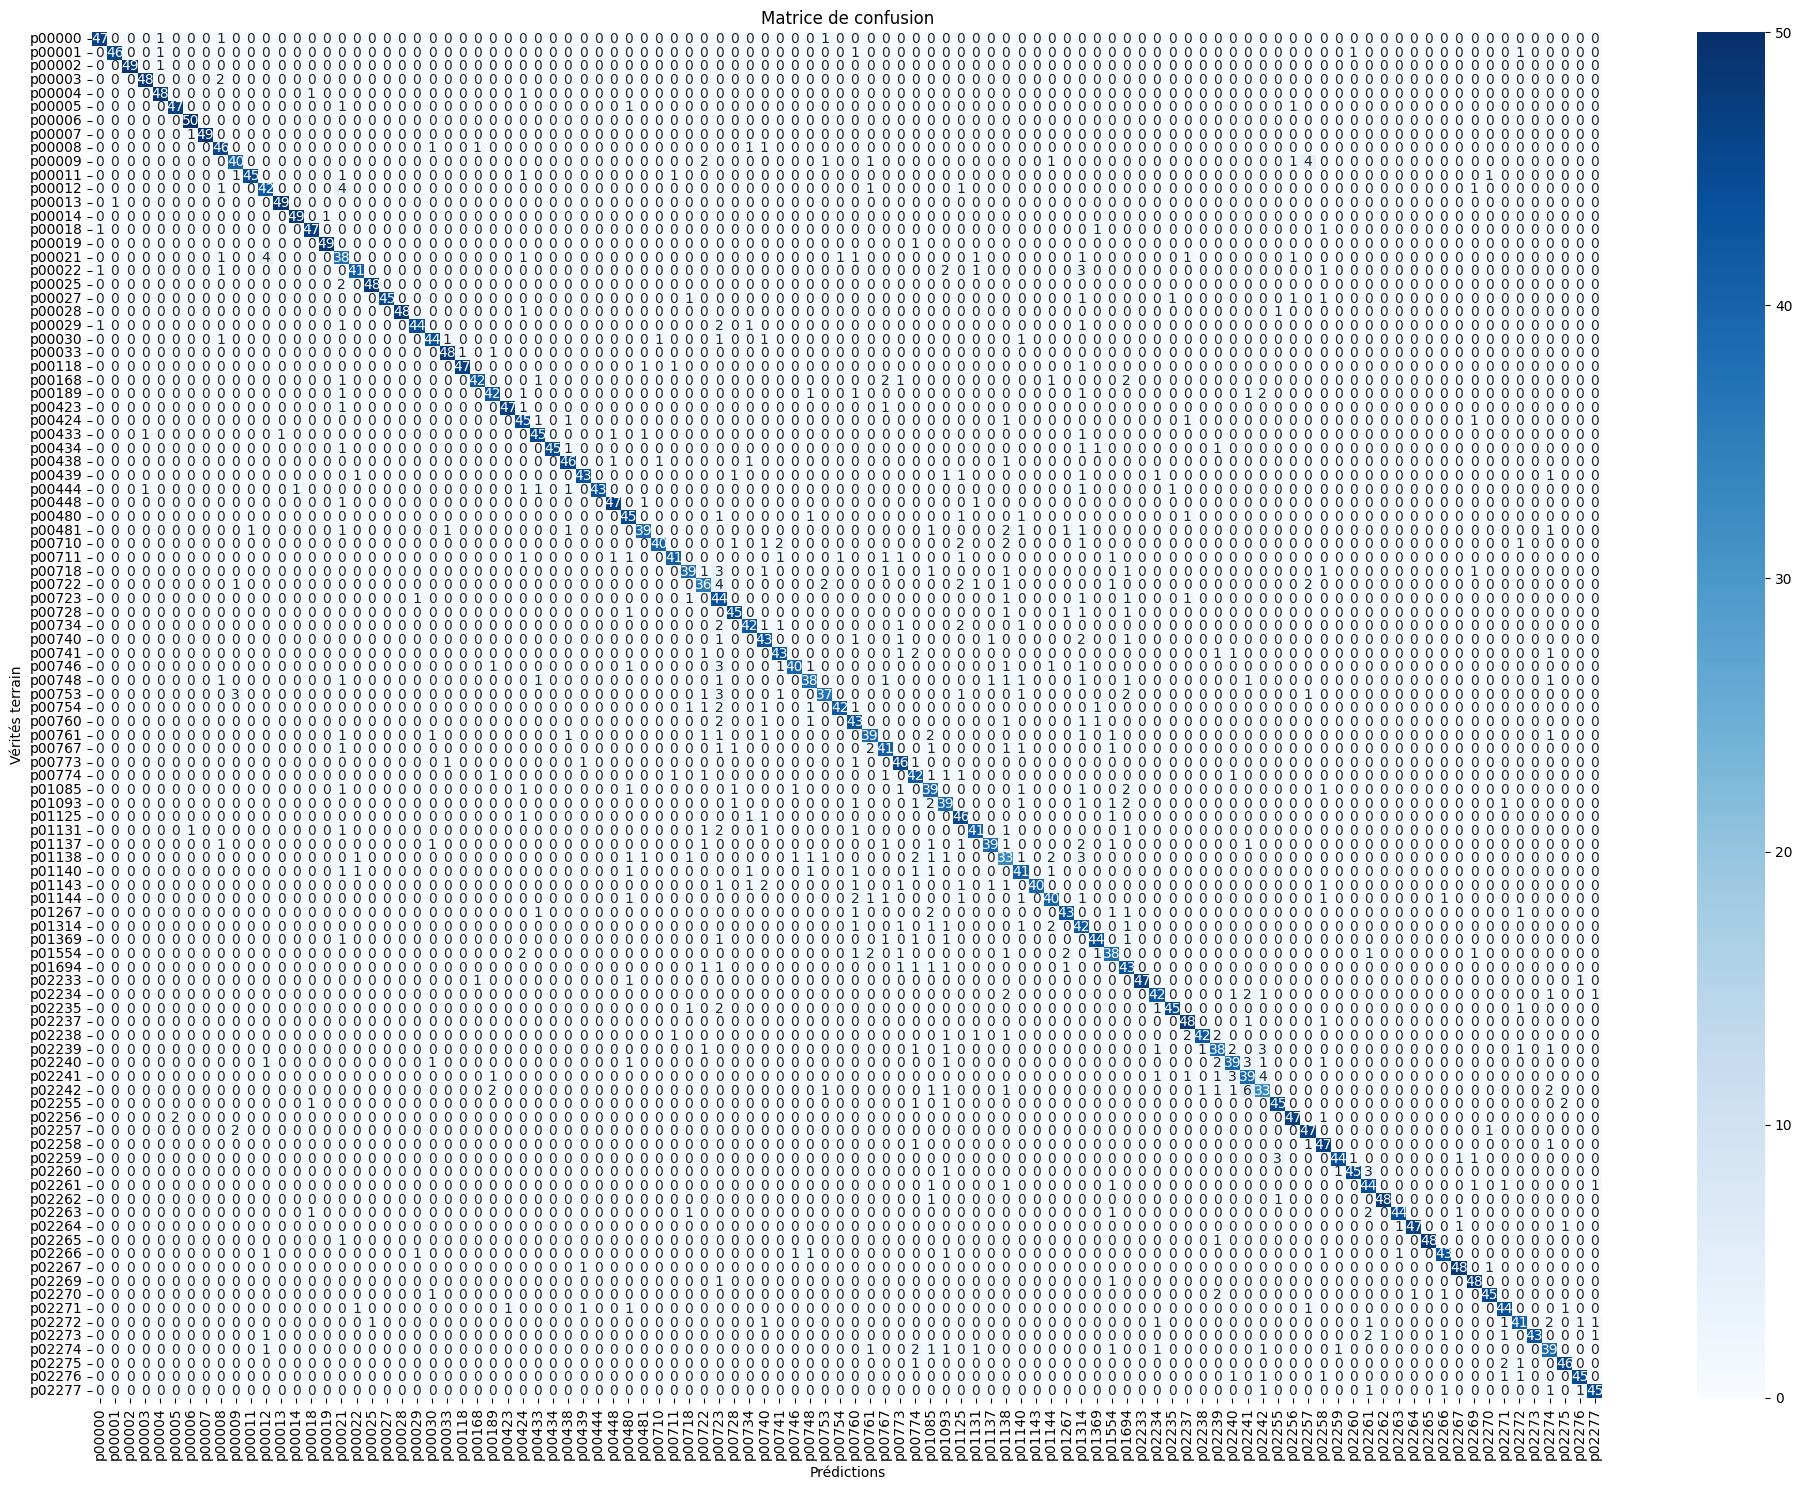

In [23]:
cm = confusion_matrix(labels, preds)
labels_ordered = [inv_map[i] for i in sorted(inv_map)]

plt.figure(figsize=(20, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_ordered, yticklabels=labels_ordered)
plt.xlabel("Prédictions")
plt.ylabel("Vérités terrain")
plt.title("Matrice de confusion")
plt.tight_layout()
plt.show()

## 📌 Final conclusion  
`CodeBERT` shows strong performance in source code classification — with room for optimization in certain classes.